# Image segmentation (with U-Nets)


In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from os import listdir
import skimage
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## U-Net Architecture
![architecture](.\architecture.png "UNet architecture")

### Contracting Path
It consits of 4 blocks and every block has the same architecture (typical architecture of a concolutional network)
1. Two 3x3 unpadded convolutions each followed by a rectified linear unit
    - because its is unpadded we loss with every convolution 2 pixels in each dimension
2. 2x2 max pooling operations with stride 2
    - with this setting the image get downsampled by a factor of 2

They start with 64 feature channels (filters) at the first block and with each block they double the number of feature channels

The output of the last block will be sended through two convoltuion layers (3x3) each followed by a ReLU, because of the doubling of the feature channels the resulting feature map for each layer is 1024 dimensional.

### Expansive Path
Its symetric to the contracting path, so again 4 blocks. However the architecture changes slightly
1. Upsampling by a 2x2 up-convolution (that halves the number of feature channels)
2. Copy a cropped version of the feature map from the corresponding feature map of the contracting path and concatenate with the upsampled feature map
    - The cropping is necessary due to the loss of border pixels in every convolution
3. Two 3x3 unpadded convolutions each followed by a rectified linear unit

At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes (in our case 2 classes). 

In total the network has 23 convolutional layers. (2\*4 (Contracting Path) + 2 (last layer) + 3\*4 (Expansive Path) + 1 (final layer))

In [2]:
# because 18 of the 23 convolutional layers uses the same setting, we defined a own function for this
def conv3x3(_input, output):
    return nn.Conv2d(_input, output, 3, padding=1)

def conv_upsample(in_channels,channels,i):
    # a = (i+2p-k)mod s
    s = 2
    k = 2
    p = 0
    a = np.mod(i+2*p-k,s)
    return nn.ConvTranspose2d(in_channels=in_channels, out_channels=channels, kernel_size=k, stride=s, output_padding=a)


# define block of contracting path
class ContractingBlock(nn.Module):
    def __init__(self,in_channels,channels):
        super(ContractingBlock, self).__init__()
        # for the first conv layer the number of input channels are the number of channels form the previous block and they will be doubled (first block starts with 64) 
        self.conv1 = conv3x3(in_channels,channels)
        self.conv2 = conv3x3(channels,channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample_block = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x, isInitBlock = 0):
        if not isInitBlock:
            x = self.downsample_block(x)
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        #print(x.size())
        
        return x

# define block of expansive path
class ExpansiveBlock(nn.Module):
    def __init__(self, in_channels, channels,target_size):
        super(ExpansiveBlock, self).__init__()
        self.upsampled = conv_upsample(in_channels, channels,target_size)
        self.conv1 = conv3x3(in_channels,channels)
        self.conv2 = conv3x3(channels,channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x, cop):
        x = self.upsampled(x)
        #n, c, h, w = x.size()
        #cop = cop[0:n,0:c,0:h,0:w]
        x = torch.cat([cop, x], dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        #print(x.size())
        
        return x


In [12]:
class UNet(nn.Module):
    def __init__(self, nrChannels):
        super(UNet, self).__init__()
        self.contracted1 = ContractingBlock(3,nrChannels)
        self.contracted2 = ContractingBlock(nrChannels,2*nrChannels)
        self.contracted3 = ContractingBlock(2*nrChannels,4*nrChannels)
        self.contracted4 = ContractingBlock(4*nrChannels,8*nrChannels)
        self.bottom = ContractingBlock(8*nrChannels,16*nrChannels)
        self.expanded1 = ExpansiveBlock(16*nrChannels,8*nrChannels,73)
        self.expanded2 = ExpansiveBlock(8*nrChannels,4*nrChannels,146)
        self.expanded3 = ExpansiveBlock(4*nrChannels,2*nrChannels,292)
        self.expanded4 = ExpansiveBlock(2*nrChannels,nrChannels,584)
        self.final = nn.Conv2d(nrChannels, 2, 1, padding=0)
        
    def forward(self,x):
        con1 = self.contracted1(x, 1)
        con2 = self.contracted2(con1)
        con3 = self.contracted3(con2)
        con4 = self.contracted4(con3)
        bot = self.bottom(con4)
        exp1 = self.expanded1(bot,con4)
        exp2 = self.expanded2(exp1,con3)
        exp3 = self.expanded3(exp2,con2)
        exp4 = self.expanded4(exp3,con1)
        fin = self.final(exp4)
        
        return fin

unet = UNet(16)

## Loss-Function
For the loss a pixel-wise soft-max over the final feature map combined with the corss entropy loss function is computed.
The function torch.nn.functional.corss_entropy() does exactly this.

In [4]:
def EngergyFunction(featuremap, target):
    featuremap = featuremap.transpose(1, 2).transpose(2, 3).contiguous().view(-1, 2)
    target = target/255
    target = target+1
    target = target.contiguous().view(-1)
    loss = F.cross_entropy(featuremap, target,reduction='elementwise_mean',)
    
    return loss
        

## Optimizer
Like described in [1] we use stochastic gradient descent with a momentum of 0.99 for optimization.

In [5]:
optimizer = optim.SGD(
        unet.parameters(), 
        lr=0.01)

## Dataloader

In [6]:
def dataLister(image_path,label_path):
    data = listdir(image_path)
    labels = listdir(label_path)    
    combined = list()
    for d, l in zip(data, labels):
        combined.append((image_path + d, label_path + l))
        
    return combined

In [8]:
class SegmentationDataset(data.Dataset):
    def __init__(self, datalist):
        self.datalist = datalist
        self.transforms = transforms.ToTensor()
        
    def __len__(self):
        return len(self.datalist)
    
    def __getitem__(self, index):
        image = Image.open(self.datalist[index][0])
        image = self.transforms(image)
        # padding for quadratic input
        image = F.pad(image, (19,0), 'constant', 0)
        label = Image.open(self.datalist[index][1])
        label = self.transforms(label)
        label = label.type(torch.LongTensor)
        label = F.pad(label, (19,0), 'constant', 0)
        return image,label

train_image_path = './data/training_copy/images/'
train_label_path = './data/training_copy/mask/'
test_image_path = './data/test/images/'
test_label_path = './data/test/1st_manual/'
trainlist = dataLister(train_image_path,train_label_path)
train_dataset = SegmentationDataset(trainlist)
train_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True)
testlist = dataLister(test_image_path,test_label_path)
test_dataset = SegmentationDataset(testlist)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Train Network

In [ ]:
losses = []
unet.train()
for epoch in range(1):
    epoch_loss = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        
        optimizer.zero_grad()
        
        output = unet(inputs)
        loss = EngergyFunction(output,labels)
        epoch_loss += loss.item() # logging
        
        loss.backward()
        optimizer.step()

    losses.append(epoch_loss)
    print(epoch,epoch_loss)    

C:\Users\philm\Anaconda3\lib\site-packages\torch\nn\_reduction.py:16: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


In [13]:
unet = unet.eval()

In [13]:
dataiter = iter(test_loader)
test_input, test_label = dataiter.next()
test_output = unet(test_input)
EngergyFunction(test_output,test_label)

tensor(2.1811e-10, grad_fn=<NllLossBackward>)

In [ ]:
EngergyFunction(output,labels)

In [19]:
dataiter = iter(test_loader)
test_input, test_label = dataiter.next()

In [12]:
img = np.empty([584, 584])
for i in range(584):
    for j in range(584):
        temp1 = np.absolute(output[0,0,i,j].item())
        temp2 = np.absolute(output[0,1,i,j].item())
        if temp1 > temp2:
            img[i,j] = 1;
        else:
            img[i,j] = 0;

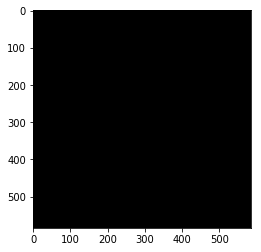

In [13]:
#imshow(torchvision.utils.make_grid(test_input))
img_01 = Image.fromarray(img,'1')
plt.imshow(img_01)
plt.show()

In [67]:
pred = np.squeeze(test.data.max(1)[0].cpu().numpy(), axis=0)

## References
[1] U-Net: Convolutional Networks for Biomedical Image Segmentation